# Equilibrating the nanotube + methane simulation

The aim of this notebook is to create an equilibrated nanotube simulation. 

We will do this in the following steps:
1. Load the current nanotube + methane simulation from SubtleGame. <= "nanotube_1_original.xml"
2. In VR, place the methane in the approx. desired position. => save as "nanotube_2.xml"
3. Run energy minimisation, perform equilibration for 5 ns, until the energies and temperature are stable. => save as "nanotube_3_equilibrated.xml"

In [1]:
from nanover.omni import OmniRunner
from nanover.omni.openmm import OpenMMSimulation
from nanover.app import NanoverImdClient
from nanover.openmm import serializer
import numpy as np
import openmm.app as app
from openmm import LangevinIntegrator
from simtk import unit
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Storing the file names

In [2]:
# 1
input_xml = "nanotube_original.xml"
# 2
nanotube_2_xml = "nanotube_2.xml"
# 3 
nanotube_3_equilibrated = "nanotube_3_equilibrated.xml"
equilibration_statedata_file = "nanotube_equilibration.dcd"
equilibration_dcd_file = "nanotube_equilibration.log"
# 4
equilibration_final_check_dcd_file = "nanotube_equilibration_final_check.dcd"
equilibration_final_check_statedata_file = "nanotube_equilibration_final_check.log"

In [11]:
# Define data labels for plotting
original_pot_energy_label = "Potential Energy (kJ/mole)"
pot_energy_label = "Potential Energy (kJ/mol)"
temp_label = "Temperature (K)"
original_step_label = '#"Step"'
sim_step_label = "Step #"
sim_step_axis_label = "Simulation time (ps)"

rolling_avg_temperature = "Rolling average temperature"
rolling_stddev_temperature = "Rolling std dev temperature"
rolling_avg_potential_energy = "Rolling average potential energy"
rolling_stddev_potential_energy = "Rolling std dev potential energy"

simulation_name= "nanotube + methane"
simulation_title_for_files = "nanotube-methane"

def rename_df_headings(df):
    df = df.rename(columns={'#"Step"': sim_step_label})
    df = df.rename(columns={original_pot_energy_label: pot_energy_label})
    return df

# For plotting trajectory data
def plot_data(df, y_label, rolling_avg_col, rolling_std_col, color, ylim, xlim, title, xtick_stepsize, filename=None):
    plt.figure(figsize=(10, 5))
    
    # Plot raw data
    plt.plot(df[sim_step_label], df[y_label], label=y_label, color=color, alpha=0.75)
    
    # Plot rolling mean average
    plt.plot(df[sim_step_label], df[rolling_avg_col], label=f'Rolling mean avg ({window_width} ps)', color="black", linewidth=2)
    
    # Plot rolling standard deviation as a shaded region
    plt.fill_between(df[sim_step_label], 
                     df[rolling_avg_col] - df[rolling_std_col], 
                     df[rolling_avg_col] + df[rolling_std_col], 
                     color='gray', alpha=0.5, label="Rolling std dev")

    # Formatting plot
    plt.xlabel(sim_step_axis_label)
    plt.ylabel(y_label)
    plt.ylim(ylim)
    plt.xlim(xlim)

    # Dynamically set x-ticks based on xlim, excluding non-whole step limits
    max_tick = (xlim[1] // xtick_stepsize) * xtick_stepsize  # Ensure the last tick is aligned with step size
    plt.xticks(range(int(xlim[0]), max_tick + xtick_stepsize, xtick_stepsize))
    plt.minorticks_on()

    plt.title(title)
    plt.legend(loc='lower right')

    # Show or save
    if filename:
        plt.savefig(filename)
    plt.show()

## Step 2: Moving the methane in VR

In [ ]:
original_simulation = OpenMMSimulation.from_xml_path(input_xml)
imd_runner = OmniRunner.with_basic_server(original_simulation, name="rhos-server")
imd_runner.next()

In [ ]:
# connect a client
client = NanoverImdClient.autoconnect(name="rhos-server")
client.subscribe_to_frames()
client.wait_until_first_frame();

In [ ]:
with open(nanotube_2_xml, 'w') as outfile:
    outfile.write(serializer.serialize_simulation(imd_runner.simulation.simulation))

In [ ]:
client.close()
imd_runner.close()

## Step 3: Equilibration

In [ ]:
# Load the simulation from file
simulation = OpenMMSimulation.from_xml_path(nanotube_2_xml)
simulation.load()

# Create reporters for recording the simulation
dcd_reporter = app.DCDReporter(equilibration_dcd_file, 1)
statedata_reporter = app.StateDataReporter(equilibration_statedata_file, 1, 
                                           temperature=True, step=True,
                                           time=True, potentialEnergy=True, kineticEnergy=True)

# Attach reporters
simulation.simulation.reporters.append(dcd_reporter)
simulation.simulation.reporters.append(statedata_reporter)

In [ ]:
# Set parameters
total_time_in_ps = 5000
time_step_interval_in_ps = 0.002
desired_interval_in_ps = 100

total_num_steps = total_time_in_ps/time_step_interval_in_ps
print(f"Running for {total_num_steps} steps")

# Run the dynamics
cumulative_total_time_ps = 0

for n in range(int(total_time_in_ps/desired_interval_in_ps)):
    
    simulation.simulation.step(desired_interval_in_ps)
    cumulative_total_time_ps += desired_interval_in_ps
    print(f"{cumulative_total_time_ps} ps run.")

    # Save the simulation with the serialized State
    file_name =  f"nanotube_equilibration_{cumulative_total_time_ps}_ps.xml"
    with open(file_name, 'w') as outfile:
        outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))

with open(nanotube_3_equilibrated, 'w') as outfile:
    outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))

In [ ]:
# Close the reporters
dcd_reporter.__del__()
statedata_reporter.__del__()

## Step 3.5: Analysis

In [12]:
# Load trajectory file
df = pd.read_csv(equilibration_statedata_file, sep=",")
df = rename_df_headings(df)

# Compute rolling averages
window_width = 100
rolling_metrics = {
    temp_label: (rolling_avg_temperature, rolling_stddev_temperature),
    pot_energy_label: (rolling_avg_potential_energy, rolling_stddev_potential_energy)
}

for column, (avg_col, std_col) in rolling_metrics.items():
    df[avg_col] = df[column].rolling(window=window_width, min_periods=window_width).mean()
    df[std_col] = df[column].rolling(window=window_width, min_periods=window_width).std()

In [13]:
# Plot Temperature
title = f'A plot of temperature against simulation time for the equilibration of the {simulation_name} system\nwith a rolling average \u00B1 std dev with window size {window_width} ps'

filename = f'{simulation_title_for_files}_equilibration_temperature-against-time.png'
plot_data(df, temp_label, rolling_avg_temperature, rolling_stddev_temperature, 
          "#21918c", (0, 400), (0, 5020), 
          title, 500, filename=filename)

# Plot Potential Energy
filename = f'{simulation_title_for_files}_equilibration_potential-energy-against-time.png'
title = f'A plot of potential energy against simulation time for the equilibration of the {simulation_name} system\nwith the rolling average mean \u00B1 std dev with window size {window_width} ps'

plot_data(df, pot_energy_label, rolling_avg_potential_energy, rolling_stddev_potential_energy, 
          "#440154", (200, 600), (0, 5020), 
          title, 500, filename=filename)

## Step 4: Post-equilibration run for final check of equilibration

In [6]:
# Load the simulation from file
simulation = OpenMMSimulation.from_xml_path(nanotube_3_equilibrated)
simulation.load()

# Create reporters for recording the simulation
dcd_reporter = app.DCDReporter(equilibration_final_check_dcd_file, 1)
statedata_reporter = app.StateDataReporter(equilibration_final_check_statedata_file, 1, 
                                           temperature=True, step=True,
                                           time=True, potentialEnergy=True, kineticEnergy=True)

# Attach reporters
simulation.simulation.reporters.append(dcd_reporter)
simulation.simulation.reporters.append(statedata_reporter)

In [7]:
# Set parameters
total_time_in_ps = 1500
time_step_interval_in_ps = 0.002
desired_interval_in_ps = 100

total_num_steps = total_time_in_ps/time_step_interval_in_ps
print(f"Running for {total_num_steps} steps")

# Run the dynamics
cumulative_total_time_ps = 0

for n in range(int(total_time_in_ps/desired_interval_in_ps)):
    
    simulation.simulation.step(desired_interval_in_ps)
    cumulative_total_time_ps += desired_interval_in_ps
    print(f"{cumulative_total_time_ps} ps run.")

    # Save the simulation with the serialized State
    file_name =  f"nanotube_equilibration_final_check_{cumulative_total_time_ps}_ps.xml"
    with open(file_name, 'w') as outfile:
        outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))

Running for 750000.0 steps
100 ps run.
200 ps run.
300 ps run.
400 ps run.
500 ps run.
600 ps run.
700 ps run.
800 ps run.
900 ps run.
1000 ps run.
1100 ps run.
1200 ps run.
1300 ps run.
1400 ps run.
1500 ps run.


In [8]:
# Close the reporters
dcd_reporter.__del__()
statedata_reporter.__del__()

## Step 4.5: Analysis

In [14]:
# Load trajectory file
df_final_check = pd.read_csv(equilibration_final_check_statedata_file, sep=",")
df_final_check = rename_df_headings(df_final_check)

# Compute rolling average
steps = 200
df_final_check[rolling_avg_temperature] = df_final_check[temp_label].rolling(window=steps, min_periods=1).mean()
df_final_check[rolling_stddev_temperature] = df_final_check[temp_label].rolling(window=100, min_periods=1).std()

df_final_check[rolling_avg_potential_energy] = df_final_check[pot_energy_label].rolling(window=steps, min_periods=1).mean()
df_final_check[rolling_stddev_potential_energy] = df_final_check[pot_energy_label].rolling(window=100, min_periods=1).std()

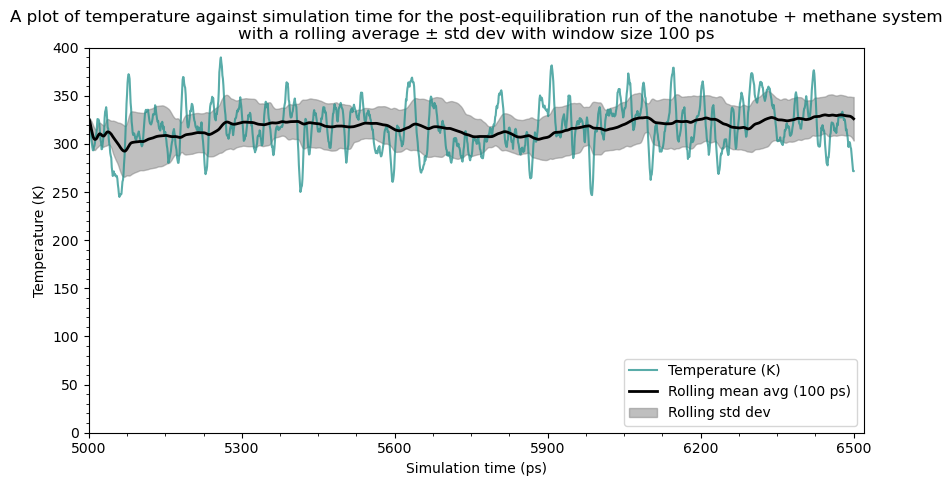

In [15]:
# Plot Temperature
title = f'A plot of temperature against simulation time for the post-equilibration run of the {simulation_name} system\nwith a rolling average \u00B1 std dev with window size {window_width} ps'
filename = f'{simulation_title_for_files}_post-equilibration-run_temperature-against-time.png'
plot_data(df_final_check, temp_label, rolling_avg_temperature, rolling_stddev_temperature, 
          "#21918c", (0, 400), (5000, 6520), 
          title, 300, filename=filename)

# Plot Potential Energy
filename = f'{simulation_title_for_files}_post-equilibration-run_potential-energy-against-time.png'
title = f'A plot of potential energy against simulation time for the post-equilibration run of the {simulation_name} system\nwith the rolling average mean \u00B1 std dev with window size {window_width} ps'
plot_data(df_final_check, pot_energy_label, rolling_avg_potential_energy, rolling_stddev_potential_energy, 
          "#440154", (200, 600), (5000, 6520), 
          title, 300, filename=filename)